   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-nu

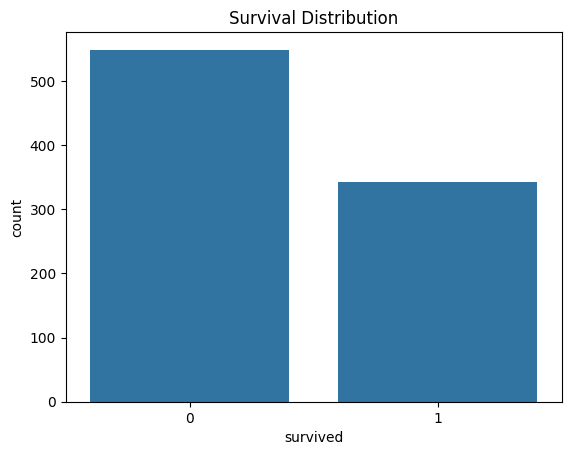

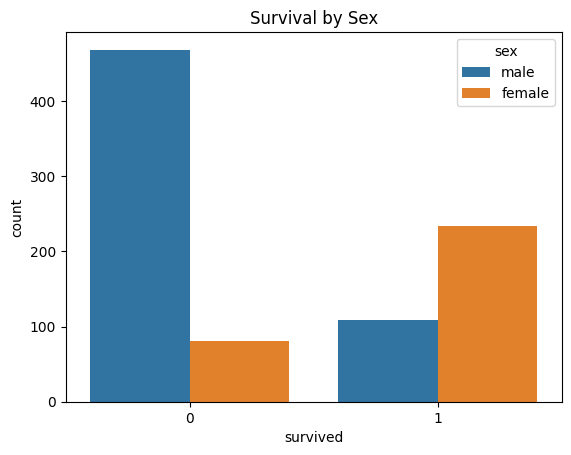

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:41:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


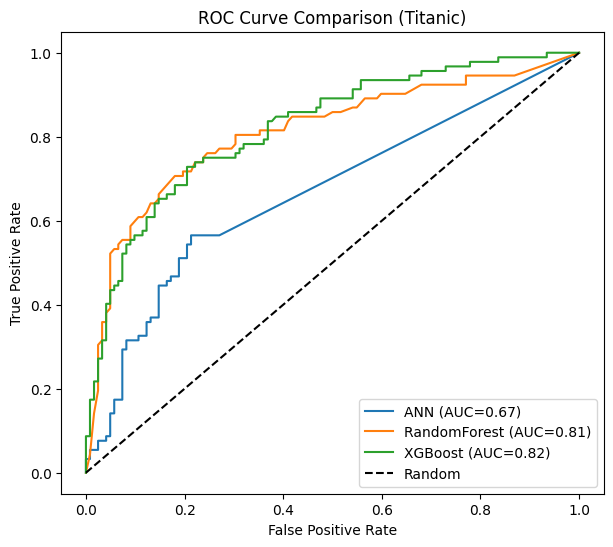

In [3]:
# 1. 라이브러리 설치 및 불러오기
!pip install -q seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 2. 데이터 불러오기 (Seaborn 내장)
df = sns.load_dataset('titanic')
print(df.head())

# 3. EDA (기초 탐색)
print(df.info())
print(df.isnull().sum())   # 결측치 확인
sns.countplot(x='survived', data=df)
plt.title('Survival Distribution')
plt.show()

# 성별 생존율
sns.countplot(x='survived', hue='sex', data=df)
plt.title('Survival by Sex')
plt.show()

# 4. 데이터 전처리
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]  # 주요 변수만 사용
df = df.dropna()   # 결측치 제거
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['embarked'] = df['embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# 5. 학습/테스트셋 분리
from sklearn.model_selection import train_test_split
X = df.drop('survived', axis=1).values
y = df['survived'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 6-1. 딥러닝(ANN) 모델
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.2)

# 6-2. 랜덤포레스트 모델
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)[:,1]

# 6-3. XGBoost 모델
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_proba = xgb.predict_proba(X_test)[:,1]

# 7. ROC, AUC 계산 및 시각화
from sklearn.metrics import roc_curve, roc_auc_score

# 딥러닝 예측 확률
ann_proba = model.predict(X_test).ravel()

# ROC Curve와 AUC 계산
fpr_ann, tpr_ann, _ = roc_curve(y_test, ann_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
auc_ann = roc_auc_score(y_test, ann_proba)
auc_rf = roc_auc_score(y_test, rf_proba)
auc_xgb = roc_auc_score(y_test, xgb_proba)

# 한 번에 시각화
plt.figure(figsize=(7,6))
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC={auc_ann:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.2f})')
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Titanic)')
plt.legend()
plt.show()